In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

In [25]:
import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm.notebook import tqdm
%matplotlib inline

In [26]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,),std=(0.5,))
              ])

dataset = FashionMNIST(root='./data',train=True,transform=transform,download=True)

In [27]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [28]:
batch_size = 100
train_loader = DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=3,pin_memory=True)

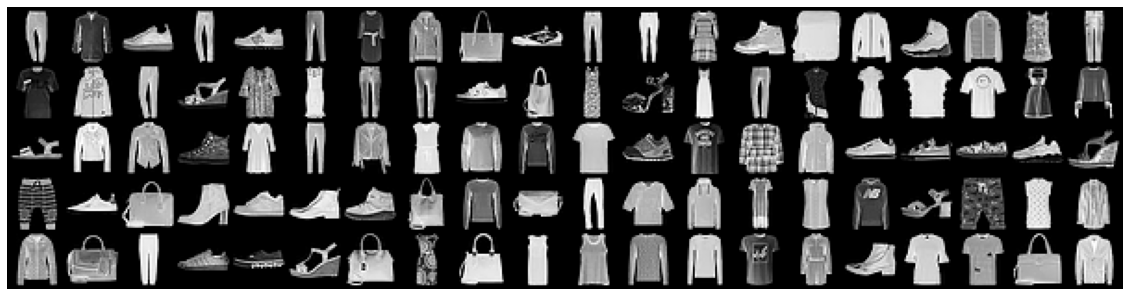

In [29]:
for image,label in train_loader:
  plt.figure(figsize=(20,6))
  plt.imshow(make_grid(denorm(image),nrow=20).permute(1,2,0))
  plt.axis('off')
  plt.show()
  break

In [30]:
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

device = get_device()
device

device(type='cuda')

In [31]:
image_shape = 784
hidden_shape = 256
latent_size = 64

In [32]:
discriminator = nn.Sequential(
    nn.Linear(image_shape,hidden_shape),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_shape,hidden_shape),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_shape,1),
    nn.Sigmoid()
)

In [33]:
generator = nn.Sequential(
    nn.Linear(latent_size,hidden_shape),
    nn.ReLU(),
    nn.Linear(hidden_shape,hidden_shape),
    nn.ReLU(),
    nn.Linear(hidden_shape,image_shape),
    nn.Tanh()
)

In [34]:
xb = torch.randn(2,64)
out = generator(xb)

img = out.reshape(-1,28,28)

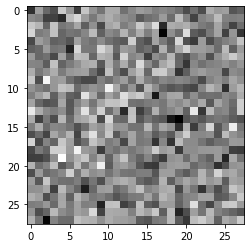

In [35]:
plt.imshow(denorm(img[0].detach()),cmap='gray')

In [36]:
discriminator = discriminator.to(device)
generator = generator.to(device)

In [37]:
g_optimizer = torch.optim.Adam(generator.parameters(),lr=0.0002)
d_optimizer = torch.optim.Adam(discriminator.parameters(),lr=0.0002)

In [38]:
def train_discriminator(real_images):
  
  d_optimizer.zero_grad()
  real_labels = torch.ones(batch_size,1).to(device)
  fake_labels = torch.zeros(batch_size,1).to(device)

  real_out = discriminator(real_images)
  real_loss = F.binary_cross_entropy(real_out,real_labels)
  real_score = real_out

  z = torch.randn(batch_size,latent_size).to(device)
  fake_images = generator(z)
  fake_out = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_out,fake_labels)
  fake_score = fake_out

  d_loss = real_loss + fake_loss

  d_loss.backward()
  d_optimizer.step()
  
  return d_loss,real_score,fake_score

In [39]:
def train_generator():

  g_optimizer.zero_grad()
  z = torch.randn(batch_size,latent_size).to(device)
  fake_images = generator(z)
  labels = torch.ones(batch_size,1).to(device)

  g_loss = F.binary_cross_entropy(discriminator(fake_images),labels)

  g_loss.backward()
  g_optimizer.step()

  return g_loss

In [40]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [41]:
sample_vectors = torch.randn(100, latent_size).to(device)

def save_fake_images(index):
    fake_images = generator(sample_vectors)
    fake_images = fake_images.reshape(-1, 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

Saving fake_images-0000.png


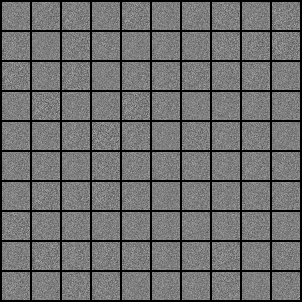

In [42]:
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [43]:
def fit(num_epochs):
  d_losses = []
  g_losses = []
  real_scores = []
  fake_scores = []
  for epoch in range(num_epochs):

    for images,labels in tqdm(train_loader):
      images = images.reshape(batch_size, -1).to(device)
      d_loss, real_score, fake_score = train_discriminator(images)
      g_loss = train_generator()
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())
    real_scores.append(real_score.mean().item())
    fake_scores.append(fake_score.mean().item())

    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
              .format(epoch+1, num_epochs, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))
        
    save_fake_images(epoch+1)

  return d_losses,g_losses,real_scores,fake_scores

In [44]:
history = fit(50)


Epoch [1/50], d_loss: 0.0914, g_loss: 4.8713, D(x): 0.96, D(G(z)): 0.04
Saving fake_images-0001.png



Epoch [2/50], d_loss: 0.0061, g_loss: 6.4462, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0002.png



Epoch [3/50], d_loss: 0.0054, g_loss: 7.1300, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0003.png



Epoch [4/50], d_loss: 0.0900, g_loss: 5.2626, D(x): 0.98, D(G(z)): 0.05
Saving fake_images-0004.png



Epoch [5/50], d_loss: 0.0337, g_loss: 5.6946, D(x): 0.99, D(G(z)): 0.03
Saving fake_images-0005.png



Epoch [6/50], d_loss: 0.2749, g_loss: 6.0077, D(x): 0.91, D(G(z)): 0.02
Saving fake_images-0006.png



Epoch [7/50], d_loss: 0.1336, g_loss: 4.3311, D(x): 0.96, D(G(z)): 0.06
Saving fake_images-0007.png



Epoch [8/50], d_loss: 0.1734, g_loss: 3.4815, D(x): 0.96, D(G(z)): 0.08
Saving fake_images-0008.png



Epoch [9/50], d_loss: 0.1431, g_loss: 4.9909, D(x): 0.95, D(G(z)): 0.05
Saving fake_images-0009.png



Epoch [10/50], d_loss: 0.1506, g_loss: 4.1220, D(x): 0.96, D(G(z)): 0.08
Saving fake_images-0010.png



Epoch [11/50], d_loss: 0.2539, g_loss: 4.7476, D(x): 0.91, D(G(z)): 0.03
Saving fake_images-0011.png



Epoch [12/50], d_loss: 0.3591, g_loss: 5.2097, D(x): 0.92, D(G(z)): 0.07
Saving fake_images-0012.png



Epoch [13/50], d_loss: 0.2672, g_loss: 4.6750, D(x): 0.90, D(G(z)): 0.06
Saving fake_images-0013.png



Epoch [14/50], d_loss: 0.2984, g_loss: 4.2087, D(x): 0.88, D(G(z)): 0.05
Saving fake_images-0014.png



Epoch [15/50], d_loss: 0.3010, g_loss: 3.2196, D(x): 0.90, D(G(z)): 0.09
Saving fake_images-0015.png



Epoch [16/50], d_loss: 0.3550, g_loss: 4.7120, D(x): 0.92, D(G(z)): 0.10
Saving fake_images-0016.png



Epoch [17/50], d_loss: 0.4175, g_loss: 3.2340, D(x): 0.88, D(G(z)): 0.08
Saving fake_images-0017.png



Epoch [18/50], d_loss: 0.4543, g_loss: 3.6208, D(x): 0.93, D(G(z)): 0.22
Saving fake_images-0018.png



Epoch [19/50], d_loss: 0.2126, g_loss: 4.1419, D(x): 0.93, D(G(z)): 0.08
Saving fake_images-0019.png



Epoch [20/50], d_loss: 0.2579, g_loss: 2.8577, D(x): 0.91, D(G(z)): 0.08
Saving fake_images-0020.png



Epoch [21/50], d_loss: 0.5711, g_loss: 3.4880, D(x): 0.89, D(G(z)): 0.20
Saving fake_images-0021.png



Epoch [22/50], d_loss: 0.4875, g_loss: 3.0422, D(x): 0.87, D(G(z)): 0.18
Saving fake_images-0022.png



Epoch [23/50], d_loss: 0.4650, g_loss: 4.6560, D(x): 0.89, D(G(z)): 0.13
Saving fake_images-0023.png



Epoch [24/50], d_loss: 0.3752, g_loss: 4.3221, D(x): 0.88, D(G(z)): 0.06
Saving fake_images-0024.png



Epoch [25/50], d_loss: 0.2755, g_loss: 3.5956, D(x): 0.93, D(G(z)): 0.10
Saving fake_images-0025.png



Epoch [26/50], d_loss: 0.3458, g_loss: 3.5418, D(x): 0.88, D(G(z)): 0.09
Saving fake_images-0026.png



Epoch [27/50], d_loss: 0.3475, g_loss: 3.6426, D(x): 0.87, D(G(z)): 0.08
Saving fake_images-0027.png



Epoch [28/50], d_loss: 0.4406, g_loss: 3.1562, D(x): 0.87, D(G(z)): 0.09
Saving fake_images-0028.png



Epoch [29/50], d_loss: 0.3404, g_loss: 3.6513, D(x): 0.89, D(G(z)): 0.13
Saving fake_images-0029.png



Epoch [30/50], d_loss: 0.4299, g_loss: 3.3068, D(x): 0.92, D(G(z)): 0.20
Saving fake_images-0030.png



Epoch [31/50], d_loss: 0.4826, g_loss: 3.6068, D(x): 0.85, D(G(z)): 0.07
Saving fake_images-0031.png



Epoch [32/50], d_loss: 0.4539, g_loss: 4.0022, D(x): 0.86, D(G(z)): 0.16
Saving fake_images-0032.png



Epoch [33/50], d_loss: 0.5218, g_loss: 2.7028, D(x): 0.89, D(G(z)): 0.24
Saving fake_images-0033.png



Epoch [34/50], d_loss: 0.5458, g_loss: 2.7806, D(x): 0.84, D(G(z)): 0.14
Saving fake_images-0034.png



Epoch [35/50], d_loss: 0.4727, g_loss: 2.8955, D(x): 0.85, D(G(z)): 0.16
Saving fake_images-0035.png



Epoch [36/50], d_loss: 0.5540, g_loss: 3.2615, D(x): 0.87, D(G(z)): 0.22
Saving fake_images-0036.png



Epoch [37/50], d_loss: 0.4648, g_loss: 2.5443, D(x): 0.91, D(G(z)): 0.21
Saving fake_images-0037.png



Epoch [38/50], d_loss: 0.3882, g_loss: 2.6235, D(x): 0.90, D(G(z)): 0.17
Saving fake_images-0038.png



Epoch [39/50], d_loss: 0.4171, g_loss: 2.5911, D(x): 0.89, D(G(z)): 0.18
Saving fake_images-0039.png



Epoch [40/50], d_loss: 0.7509, g_loss: 2.3800, D(x): 0.79, D(G(z)): 0.17
Saving fake_images-0040.png



Epoch [41/50], d_loss: 0.6388, g_loss: 2.8381, D(x): 0.81, D(G(z)): 0.16
Saving fake_images-0041.png



Epoch [42/50], d_loss: 0.6431, g_loss: 3.0291, D(x): 0.83, D(G(z)): 0.23
Saving fake_images-0042.png



Epoch [43/50], d_loss: 0.4337, g_loss: 3.0074, D(x): 0.85, D(G(z)): 0.15
Saving fake_images-0043.png



Epoch [44/50], d_loss: 0.5056, g_loss: 2.5226, D(x): 0.79, D(G(z)): 0.12
Saving fake_images-0044.png



Epoch [45/50], d_loss: 0.7248, g_loss: 2.1472, D(x): 0.79, D(G(z)): 0.23
Saving fake_images-0045.png



Epoch [46/50], d_loss: 0.5872, g_loss: 2.7885, D(x): 0.87, D(G(z)): 0.26
Saving fake_images-0046.png



Epoch [47/50], d_loss: 0.6186, g_loss: 3.0650, D(x): 0.76, D(G(z)): 0.16
Saving fake_images-0047.png



Epoch [48/50], d_loss: 0.7011, g_loss: 2.3761, D(x): 0.87, D(G(z)): 0.29
Saving fake_images-0048.png



Epoch [49/50], d_loss: 0.7888, g_loss: 2.9898, D(x): 0.76, D(G(z)): 0.21
Saving fake_images-0049.png



Epoch [50/50], d_loss: 0.5672, g_loss: 3.1094, D(x): 0.83, D(G(z)): 0.20
Saving fake_images-0050.png


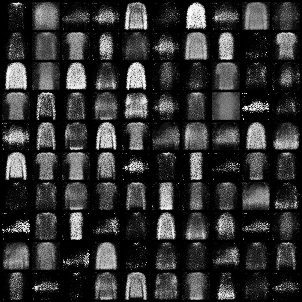

In [53]:
Image('./samples/fake_images-0020.png')

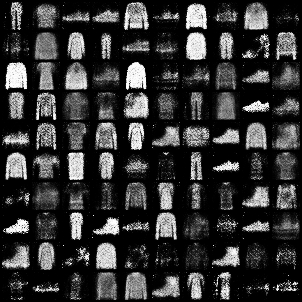

In [55]:
Image('./samples/fake_images-0050.png')

### Training for more epochs will give better results